In [1]:
library(tidyverse)
library(cowplot)

fc <- read.csv('C:/Users/Adrian/OneDrive - UNSW/Documents/papers/preparation/wild_deserts_vegetation_change/comparison_fc_v3.csv')
fc$satTotal <- fc$satPV + fc$satNPV
fc$droneTotal <- fc$droneAlive + fc$droneDead
head(fc)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'cowplot' was built under R version 3.6.3"

Id,Ident,date,droneAlive,droneDead,satPV,satNPV,satTotal,droneTotal
10,S4 SWALE,2018.375,1.3026,3.4110,1.0000,9.0000,10.0000,4.7136
10,S4 SWALE,2019.375,0.5039,0.6417,1.0000,8.6667,9.6667,1.1456
10,S4 SWALE,2020.375,3.1925,0.0048,1.0833,11.3333,12.4166,3.1973
10,S4 SWALE,2021.375,22.5426,0.0281,3.0833,25.4167,28.5000,22.5707
10,S4 SWALE,2022.375,20.3045,1.0145,1.1667,22.4167,23.5834,21.3190
11,W2 SWALE,2018.375,0.7515,5.9558,0.8333,13.4167,14.2500,6.7073



Call:
lm(formula = droneAlive ~ 0 + satPV, data = fc)

Residuals:
    Min      1Q  Median      3Q     Max 
-59.783  -3.252   0.393   8.414  51.161 

Coefficients:
      Estimate Std. Error t value Pr(>|t|)    
satPV   4.3929     0.1493   29.43   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14.19 on 346 degrees of freedom
Multiple R-squared:  0.7145,	Adjusted R-squared:  0.7137 
F-statistic: 865.8 on 1 and 346 DF,  p-value: < 2.2e-16


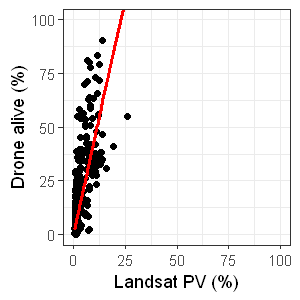

In [2]:
# Develop model for PV
aliveModel <- lm(data = fc, droneAlive ~ 0 + satPV)
summary(aliveModel)
fc$predicted_alive <- predict(aliveModel)
options(repr.plot.width=2.5, repr.plot.height=2.5)
ggplot(fc, aes(x = satPV, y = droneAlive)) +
       geom_point() +
       labs(x = "Landsat PV (%)", y = "Drone alive (%)") +
       theme_bw() +
       geom_line(aes(y = predicted_alive), size = 1, color = 'red') +
       coord_cartesian(xlim=c(0, 100),
                       ylim=c(0, 100))


Call:
lm(formula = droneTotal ~ satTotal, data = fc)

Residuals:
    Min      1Q  Median      3Q     Max 
-26.884  -7.614  -1.905   5.435  40.625 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.32005    1.25329  -2.649  0.00844 ** 
satTotal     1.23873    0.04987  24.840  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 11.53 on 345 degrees of freedom
Multiple R-squared:  0.6414,	Adjusted R-squared:  0.6403 
F-statistic:   617 on 1 and 345 DF,  p-value: < 2.2e-16


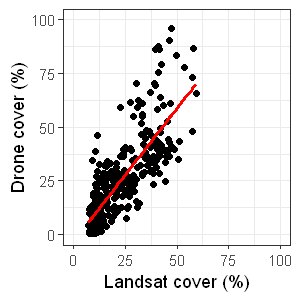

In [3]:
# Develop model for total cover
totalModel <- lm(data = fc, droneTotal ~ satTotal)
summary(totalModel)
fc$predicted_total <- predict(totalModel)
options(repr.plot.width=2.5, repr.plot.height=2.5)
ggplot(fc, aes(x = satTotal, y = droneTotal)) +
       geom_point() +
       labs(x = "Landsat cover (%)", y = "Drone cover (%)") +
       theme_bw() +
       geom_line(aes(y = predicted_total), size = 1, color = 'red') +
       coord_cartesian(xlim=c(0, 100),
                       ylim=c(0, 100))

In [4]:
# Calculate predicted NPV from the other models
fc$predicted_dead <- fc$predicted_total - fc$predicted_alive

# Calculate RMSE using LOOCV
fc$loocv_alive <- 0
fc$loocv_dead <- 0
fc$loocv_total <- 0
for (i in 1:nrow(fc)) {
    training <- fc[-i,]
    p <- lm(data = training, droneAlive ~ 0 + satPV)
    fc[i,]$loocv_alive <- predict(p, newdata=fc[i,])
    t <- lm(data = training, droneTotal ~ satTotal)
    fc[i,]$loocv_total <- predict(t, newdata=fc[i,])
    fc[i,]$loocv_dead <- fc[i,]$loocv_total - fc[i,]$loocv_alive
    }

alive_RMSE = sqrt(mean((fc$droneAlive - fc$loocv_alive)^2))
dead_RMSE = sqrt(mean((fc$droneDead - fc$loocv_dead)^2))
total_RMSE = sqrt(mean((fc$droneTotal - fc$loocv_total)^2))

In [6]:
# Plot PV, NPV and total cover with RMSE
PV_plot <- ggplot(fc, aes(x = predicted_alive, y = droneAlive)) +
           geom_point(colour = "grey") +
           labs(x = "Landsat alive (%)", y = "Drone alive (%)") +
           theme_bw() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
           geom_abline(slope = 1, intercept = 0, color = 'black', size = 0.3) +
           coord_cartesian(xlim=c(0, 100), ylim=c(0, 100)) +
           geom_text(x=2, y=97, hjust = 0, label=paste("RMSE =", format(alive_RMSE, digits=2), "%"))

NPV_plot <- ggplot(fc, aes(x = predicted_dead, y = droneDead)) +
            geom_point(colour = "grey") +
            labs(x = "Landsat dead (%)", y = "Drone dead (%)") +
            theme_bw() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
            geom_abline(slope = 1, intercept = 0, color = 'black', size = 0.3) +
            coord_cartesian(xlim=c(0, 100), ylim=c(0, 100)) +
            geom_text(x=2, y=97, hjust = 0, label=paste("RMSE =", format(dead_RMSE, digits=2), "%"))

total_plot <- ggplot(fc, aes(x = predicted_total, y = droneTotal)) +
              geom_point(colour = "grey") +
              labs(x = "Landsat total cover (%)", y = "Drone total cover (%)") +
              theme_bw() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
              geom_abline(slope = 1, intercept = 0, color = 'black', size = 0.3) +
              coord_cartesian(xlim=c(0, 100), ylim=c(0, 100)) +
              geom_text(x=2, y=97, hjust = 0, label=paste("RMSE =", format(total_RMSE, digits=2), "%"))

combined_plot <- plot_grid(PV_plot, NPV_plot, total_plot, ncol = 3, align = "h")
ggsave("C:/Users/Adrian/OneDrive - UNSW/Documents/papers/preparation/wild_deserts_vegetation_change/drone_landsat_comparison.png", combined_plot, width = 8, height = 2.7)

In [13]:
# Combine all the annual data for each site Id

fc2018 <- subset(fc, date == 2018.375)
fc2019 <- subset(fc, date == 2019.375)
fc2020 <- subset(fc, date == 2020.375)
fc2021 <- subset(fc, date == 2021.375)
fc2022 <- subset(fc, date == 2022.375)

fc2018 <- fc2018[order(fc2018$Id),]
fc2019 <- fc2019[order(fc2019$Id),]
fc2020 <- fc2020[order(fc2020$Id),]
fc2021 <- fc2021[order(fc2021$Id),]
fc2022 <- fc2022[order(fc2022$Id),]

fc2018 <- select(fc2018, Id, satPV, satNPV, satTotal, predicted_PV, predicted_total, predicted_NPV)
fc2019 <- select(fc2019, Id, satPV, satNPV, satTotal, predicted_PV, predicted_total, predicted_NPV)
fc2020 <- select(fc2020, Id, satPV, satNPV, satTotal, predicted_PV, predicted_total, predicted_NPV)
fc2021 <- select(fc2021, Id, satPV, satNPV, satTotal, predicted_PV, predicted_total, predicted_NPV)
fc2022 <- select(fc2022, Id, satPV, satNPV, satTotal, predicted_PV, predicted_total, predicted_NPV)

names(fc2018)[2] <- 'satPV_2018'
names(fc2018)[3] <- 'satNPV_2018'
names(fc2018)[4] <- 'satTotal_2018'
names(fc2018)[5] <- 'dronePV_2018'
names(fc2018)[6] <- 'droneNPV_2018'
names(fc2018)[7] <- 'droneTotal_2018'

names(fc2019)[2] <- 'satPV_2019'
names(fc2019)[3] <- 'satNPV_2019'
names(fc2019)[4] <- 'satTotal_2019'
names(fc2019)[5] <- 'dronePV_2019'
names(fc2019)[6] <- 'droneNPV_2019'
names(fc2019)[7] <- 'droneTotal_2019'

names(fc2020)[2] <- 'satPV_2020'
names(fc2020)[3] <- 'satNPV_2020'
names(fc2020)[4] <- 'satTotal_2020'
names(fc2020)[5] <- 'dronePV_2020'
names(fc2020)[6] <- 'droneNPV_2020'
names(fc2020)[7] <- 'droneTotal_2020'

names(fc2021)[2] <- 'satPV_2021'
names(fc2021)[3] <- 'satNPV_2021'
names(fc2021)[4] <- 'satTotal_2021'
names(fc2021)[5] <- 'dronePV_2021'
names(fc2021)[6] <- 'droneNPV_2021'
names(fc2021)[7] <- 'droneTotal_2021'

names(fc2022)[2] <- 'satPV_2022'
names(fc2022)[3] <- 'satNPV_2022'
names(fc2022)[4] <- 'satTotal_2022'
names(fc2022)[5] <- 'dronePV_2022'
names(fc2022)[6] <- 'droneNPV_2022'
names(fc2022)[7] <- 'droneTotal_2022'

# Make box plot like Roxanne did for the drone data
ggplot(fc2018, aes(x = siteno , y = V1)) +
       geom_boxplot ()




In [90]:
# Calculate annual changes in drone and landsat PV and NPV

fc_change <- Reduce(function(x, y) merge(x, y, all=TRUE), list(fc2018, fc2019, fc2020, fc2021, fc2022))   
                    
fc_change$satPV_2018_2019 <- fc_change$satPV_2019 - fc_change$satPV_2018
fc_change$satPV_2019_2020 <- fc_change$satPV_2020 - fc_change$satPV_2019
fc_change$satPV_2020_2021 <- fc_change$satPV_2021 - fc_change$satPV_2020
fc_change$satPV_2021_2022 <- fc_change$satPV_2022 - fc_change$satPV_2021

fc_change$dronePV_2018_2019 <- fc_change$dronePV_2019 - fc_change$dronePV_2018
fc_change$dronePV_2019_2020 <- fc_change$dronePV_2020 - fc_change$dronePV_2019
fc_change$dronePV_2020_2021 <- fc_change$dronePV_2021 - fc_change$dronePV_2020
fc_change$dronePV_2021_2022 <- fc_change$dronePV_2022 - fc_change$dronePV_2021

fc_change$satNPV_2018_2019 <- fc_change$satNPV_2019 - fc_change$satNPV_2018
fc_change$satNPV_2019_2020 <- fc_change$satNPV_2020 - fc_change$satNPV_2019
fc_change$satNPV_2020_2021 <- fc_change$satNPV_2021 - fc_change$satNPV_2020
fc_change$satNPV_2021_2022 <- fc_change$satNPV_2022 - fc_change$satNPV_2021

fc_change$droneNPV_2018_2019 <- fc_change$droneNPV_2019 - fc_change$droneNPV_2018
fc_change$droneNPV_2019_2020 <- fc_change$droneNPV_2020 - fc_change$droneNPV_2019
fc_change$droneNPV_2020_2021 <- fc_change$droneNPV_2021 - fc_change$droneNPV_2020
fc_change$droneNPV_2021_2022 <- fc_change$droneNPV_2022 - fc_change$droneNPV_2021

# Combine all change data into columns

change_2018_2019 <- select(fc_change, Id, satPV_2018_2019, dronePV_2018_2019, satNPV_2018_2019, droneNPV_2018_2019)
change_2019_2020 <- select(fc_change, Id, satPV_2019_2020, dronePV_2019_2020, satNPV_2019_2020, droneNPV_2019_2020)
change_2020_2021 <- select(fc_change, Id, satPV_2020_2021, dronePV_2020_2021, satNPV_2020_2021, droneNPV_2020_2021)
change_2021_2022 <- select(fc_change, Id, satPV_2021_2022, dronePV_2021_2022, satNPV_2021_2022, droneNPV_2021_2022)

change_2018_2019$years <- '2018-2019'
change_2019_2020$years <- '2019-2020'
change_2020_2021$years <- '2020-2021'
change_2021_2022$years <- '2021-2022'

names(change_2018_2019)[2] <- 'satPV_change'
names(change_2018_2019)[3] <- 'dronePV_change'
names(change_2018_2019)[4] <- 'satNPV_change'
names(change_2018_2019)[5] <- 'droneNPV_change'

names(change_2019_2020)[2] <- 'satPV_change'
names(change_2019_2020)[3] <- 'dronePV_change'
names(change_2019_2020)[4] <- 'satNPV_change'
names(change_2019_2020)[5] <- 'droneNPV_change'

names(change_2020_2021)[2] <- 'satPV_change'
names(change_2020_2021)[3] <- 'dronePV_change'
names(change_2020_2021)[4] <- 'satNPV_change'
names(change_2020_2021)[5] <- 'droneNPV_change'

names(change_2021_2022)[2] <- 'satPV_change'
names(change_2021_2022)[3] <- 'dronePV_change'
names(change_2021_2022)[4] <- 'satNPV_change'
names(change_2021_2022)[5] <- 'droneNPV_change'

change <- rbind(change_2018_2019, change_2019_2020, change_2020_2021, change_2021_2022)
change <- na.omit(change)

change$satTotal_change <- change$satPV_change + change$satNPV_change
change$droneTotal_change <- change$dronePV_change + change$droneNPV_change

In [93]:
# Calculate RMSE and plot
PV_change_RMSE = sqrt(mean((change$satPV_change - change$dronePV_change)^2))
NPV_change_RMSE = sqrt(mean((change$satNPV_change - change$droneNPV_change)^2))
total_change_RMSE = sqrt(mean((change$satTotal_change - change$droneTotal_change)^2))

PV_plot <- ggplot(change, aes(x = satPV_change, y = dronePV_change)) +
           geom_point(colour = "grey") +
           labs(x = "Change in drone PV (%)", y = "Change in Landsat PV (%)") +
           theme_bw() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
           geom_abline(slope = 1, intercept = 0, color = 'black', size = 0.3) +
           coord_cartesian(xlim=c(-15, 30), ylim=c(-15, 30)) +
           geom_text(x=-15, y=29, hjust = 0, label=paste("RMSE =", format(PV_change_RMSE, digits=2), "%"))

NPV_plot <- ggplot(change, aes(x = satNPV_change, y = droneNPV_change)) +
            geom_point(colour = "grey") +
            labs(x = "Change in drone NPV (%)", y = "Change in Landsat NPV (%)") +
            theme_bw() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
            geom_abline(slope = 1, intercept = 0, color = 'black', size = 0.3) +
            coord_cartesian(xlim=c(-20, 40), ylim=c(-20, 40)) +
            geom_text(x=-20, y=39, hjust = 0, label=paste("RMSE =", format(NPV_change_RMSE, digits=2), "%"))

total_plot <- ggplot(change, aes(x = satTotal_change, y = droneTotal_change)) +
              geom_point(colour = "grey") +
              labs(x = "Change in drone total (%)", y = "Change in Landsat total (%)") +
              theme_bw() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
              geom_abline(slope = 1, intercept = 0, color = 'black', size = 0.3) +
              coord_cartesian(xlim=c(-20, 40), ylim=c(-20, 40)) +
              geom_text(x=-20, y=39, hjust = 0, label=paste("RMSE =", format(total_change_RMSE, digits=2), "%"))

combined_plot <- plot_grid(PV_plot, NPV_plot, total_plot, ncol = 3, align = "h")
ggsave("C:/Users/Adrian/OneDrive - UNSW/Documents/papers/preparation/wild_deserts_vegetation_change/landsat_drone_change_comparison.png", combined_plot, width = 8, height = 2.7)

In [ ]:
# Make boxplots of mean bare, PV and NPV for each year from across the sites


